# 단열선도
- 간단한 skew T - log p daigram 그리기
- https://unidata.github.io/python-training/gallery/skewt_example/
- https://unidata.github.io/MetPy/latest/examples/Advanced_Sounding.html#sphx-glr-examples-advanced-sounding-py
- 자료는 http://weather.uwyo.edu/upperair/sounding.html 에서 받을 수 있음 (단열선도 이미지도 받을 수 있음)

# Siphon
- https://unidata.github.io/siphon/latest/index.html
- 원격서버로부터 자료를 내려받는 것을 지원하는 패키지
- 주로 미국 서버에서 지상 관측(AWS, 부이), 상층 관측, 레이더 자료 등을 받을 수 있음
- conda install -c conda-forge siphon 으로 설치

In [2]:
from datetime import datetime

import matplotlib.pyplot as plt
from metpy.plots import SkewT
import metpy.calc as mpcalc
from metpy.units import pandas_dataframe_to_unit_arrays, units
import numpy as np
from siphon.simplewebservice.wyoming import WyomingUpperAir

In [3]:
#dt = datetime(2001, 7, 14, 6)
dt = datetime(2021, 9, 21, 6)
station = 'RKSO'

# 'RKSO': 오산
# 'RKSP': 백령도
# 'RKTH': 포항
# 'RKTD': 대전
# 'RKJJ': 광주
# 'RKPC': 제주
# 'RKNN': 강릉

In [4]:
# Read remote sounding data based on time (dt) and station
df = WyomingUpperAir.request_data(dt, 47122)
df2 = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'), how='any'
               ).reset_index()
df2.units = df.units


In [5]:
# Create dictionary of united arrays
# Isolate united arrays from dictionary to individual variables

data = pandas_dataframe_to_unit_arrays(df2)
p = data['pressure']
T = data['temperature']
Td = data['dewpoint']
u = data['u_wind']
v = data['v_wind']

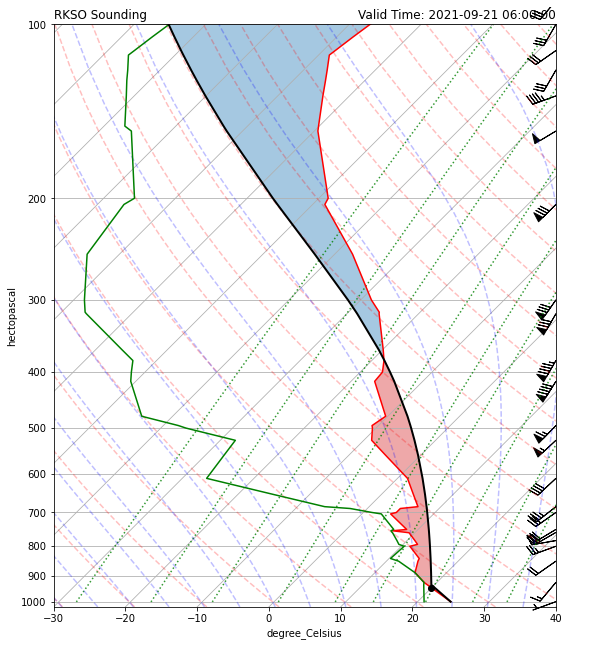

In [6]:
# Change default to be better for skew-T
fig = plt.figure(figsize=(9, 11))

# Initiate the skew-T plot type from MetPy class loaded earlier
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p[::2], u[::2], v[::2], y_clip_radius=0.03)

# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, prof)#, dewpoint=Td) # if dewpoint, CIN above Equilibrium level is not shaded.
skew.shade_cape(p, T, prof)

# Set some appropriate axes limits for x and y
skew.ax.set_xlim(-30, 40)
skew.ax.set_ylim(1020, 100)

# Add the relevant special lines to plot throughout the figure


skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25)#, color='orangered')
skew.plot_mixing_lines(pressure=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted')#, color='green')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25)#, color='tab:blue')


# Add some descriptive titles
plt.title('{} Sounding'.format(station), loc='left')
plt.title('Valid Time: {}'.format(dt), loc='right');

In [7]:
# get condensation levels
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
lfc_pressure, lfc_temperature = mpcalc.lfc(p, T, Td, prof)
cape, cin = mpcalc.cape_cin(p, T, Td, prof)
print(lcl_pressure, lfc_pressure)
print(cape, cin)

946.2626625780659 hectopascal 946.2626625780659 hectopascal
750.1897746299888 joule / kilogram 0.0 joule / kilogram
